<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/Playground2_Run_Models_compare_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [4]:
start_time <- Sys.time()
# Comment after installation so that the whole notebook can be run in one go
install.packages('xgboost')
install.packages('ggplot2')
install.packages('plotly')
install.packages('pROC')
install.packages('lightgbm')
#install.packages('shapper')
install.packages("caret")
install.packages('gbm')
install.packages("knitr")
end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Installation of libraries took: ", round(elapsed_time/60, 2), " minutes"))

# "Installation of libraries took:  25.16  minutes"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘later’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecif

[1] "Installation of libraries took:  25.16  minutes"


In [9]:
install.packages('reshape2')
 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
#Todo 
# Add time taken by each model
# Predict on train data so that overfitting can be estimated / understood
# 

# Load Libraries

In [34]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(ggplot2)

library(gbm)
library(lightgbm)

library(knitr)
library(plotly)
library(pROC)

library(caret)
library(knitr)

library(reshape2 )
#library(gt)
#library(measures)

# Load CSV datafile - Data split as train and test (80/20 split) and stored in git

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [35]:
train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
train_data <- read.csv(file =train_file, header = TRUE )
test_data <- read.csv(file =test_file, header = TRUE )
x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
y_train <- train_data$claim_count_pd
x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
y_test <- test_data$claim_count_pd

#XGboost with standard hyperparameters ( no tuning) 

In [36]:
print(colnames(x_train))

 [1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_to

In [37]:
dtrain <- xgb.DMatrix(data = as.matrix(x_train)
                        , label = y_train
  )
  dtest <- xgb.DMatrix(data = as.matrix(x_test)
                       , label = y_test
  )

In [15]:
pos_weight <- sum(y_train == 0) / sum(y_train == 1)
print(pos_weight)
fit <- xgboost(data = dtrain, nrounds = 500, objective = "binary:logistic", eta = 0.3, max_depth = 6,eval_metric = "auc",scale_pos_weight = pos_weight,silent = 1,verbose = 0)
pred_y_test <- predict(fit, dtest) # Predict the classes for the test data
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test)
roc <- roc(y_test, pred_y_test_bin)
print(roc)

[1] 8.975062
[13:08:19] WARNING: src/learner.cc:767: 
Parameters: { "silent" } are not used.



Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = y_test, predictor = pred_y_test_bin)

Data: pred_y_test_bin in 71980 controls (y_test 0) < 8020 cases (y_test 1).
Area under the curve: 0.9587


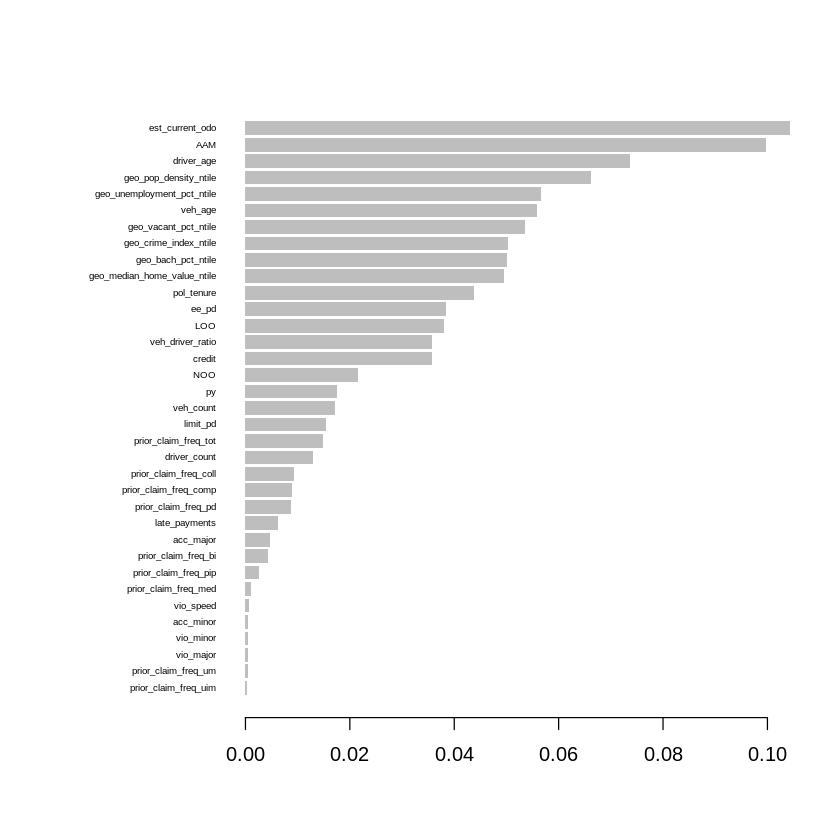

In [16]:
importance_matrix <- xgb.importance(colnames(dtrain), model = fit)
importance_matrix <- subset(importance_matrix, select = c(Feature,Gain))
  
xgb.plot.importance(importance_matrix) 
top_10_features <- head(importance_matrix$Feature, 20)

In [17]:
print(top_10_features)

 [1] "est_current_odo"             "AAM"                        
 [3] "driver_age"                  "geo_pop_density_ntile"      
 [5] "geo_unemployment_pct_ntile"  "veh_age"                    
 [7] "geo_vacant_pct_ntile"        "geo_crime_index_ntile"      
 [9] "geo_bach_pct_ntile"          "geo_median_home_value_ntile"
[11] "pol_tenure"                  "ee_pd"                      
[13] "LOO"                         "veh_driver_ratio"           
[15] "credit"                      "NOO"                        
[17] "py"                          "veh_count"                  
[19] "limit_pd"                    "prior_claim_freq_tot"       


In [18]:
x_train_top10 <- x_train[, c(top_10_features)]
x_test_top10 <- x_test[, c(top_10_features)]
#print(x_train)



In [19]:
# Fit a GLM
weight_vector <- ifelse(y_train == 1, 10, 1)
fit <- step(glm(y_train ~ ., data = x_train_top10, family = "gaussian"), direction = "both", trace = FALSE,weights = weight_vector)
pred_y_test <- predict(fit, newdata = x_test_top10, type = "response")
pred_y_test_bin = ifelse(pred_y_test > 0.1, 1, 0)
dataout_GLM_top10 <- data.frame(pred_y_test_bin, y_test)

In [21]:
weight_vector

[1] 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   [25]  1  1  1  1  1  1  1  1  1  1  1 10  1  1 10  1  1  1  1  1 10  1  1  1
   [49]  1  1  1  1  1 10  1 10  1  1  1  1  1  1  1  1 10  1  1 10  1  1  1  1
   [73] 10  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   [97]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1
  [121]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1
  [145]  1  1  1  1  1 10  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1
  [169]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1
  [193]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10 10  1  1
  [217] 10  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [241]  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1 10  1  1
  [265]  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [289]  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [313] 10  1  1 10  1  1  1  1  1  1 10  1 10  1  1 10  1  1  1  1  1  1  1 10
  [337]  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1 10  1 10  1 10  1 10
  [361] 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1
  [385]  1  1  1  1  1  1 10  1  1 10  1  1  1  1  1 10  1  1  1  1  1 10 10  1
  [409] 10  1 10 10  1  1  1  1  1  1  1  1 10  1  1 10  1  1  1  1  1  1  1  1
  [433]  1  1  1 10  1  1  1  1  1 10  1  1  1 10  1  1  1  1 10 10  1  1  1  1
  [457]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1
  [481]  1  1 10  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1
  [505]  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [529]  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10 10  1  1
  [553]  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1
  [577]  1  1  1  1  1 10  1 10  1  1 10 10  1  1  1  1  1  1  1  1  1  1  1  1
  [601]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [625] 10  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [649]  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1
  [673]  1  1  1  1  1 10  1  1 10  1  1  1 10  1  1  1  1  1 10  1  1 10 10  1
  [697]  1  1  1  1  1 10  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  [721]  1  1  1 10  1  1  1  1  1  1  1  1 10  1  1  1  1  1 10  1  1  1  1  1
  [745]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1 10
  [769]  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1
  [793]  1 10  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1 10  1  1  1  1
  [817] 10 10  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1 10
  [841]  1  1  1  1  1  1 10  1 10  1  1  1  1  1 10  1  1  1  1  1  1  1  1 10
  [865] 10  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1
  [889] 10  1  1  1  1 10  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1
  [913]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1
  [937]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10 10
  [961]  1  1 10 10  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1 10  1  1
  [985]  1  1  1  1  1  1 10  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 [1009]  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 [1033]  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 [1057]  1  1  1  1  1  1 10  1  1  1 10  1  1  1  1  1  1  1  1  1  1 10 10  1
 [1081] 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 [1105]  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 [1129] 10  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1
 [1153]  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1 10
 [1177]  1  1  1  1  1  1  1  1  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1
 [12

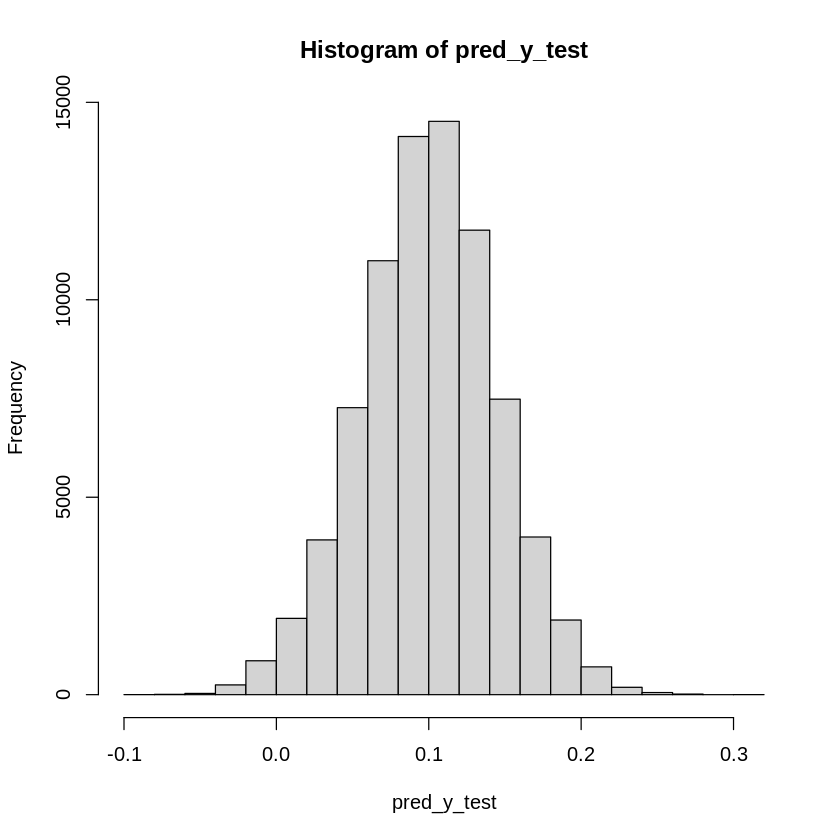

In [22]:
hist(pred_y_test)

In [23]:
conf_mat <- table(y_test, pred_y_test_bin)
print(conf_mat)

      pred_y_test_bin
y_test     0     1
     0 36848 35132
     1  2544  5476


In [24]:
# Fit a GLM
fit <- step(glm(y_train ~ ., data = x_train, family = "gaussian"), direction = "both", trace = FALSE)
pred_y_test <- predict(fit, newdata = x_test, type = "response")
pred_y_test_bin = ifelse(pred_y_test > 0.1, 1, 0)
dataout_GLM <- data.frame(pred_y_test_bin, y_test)

In [38]:
colnames(x_train)

[1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_tot"        "AAM"                        
[33] "NOO"                         "LOO"                        
[35] "est_current_odo"

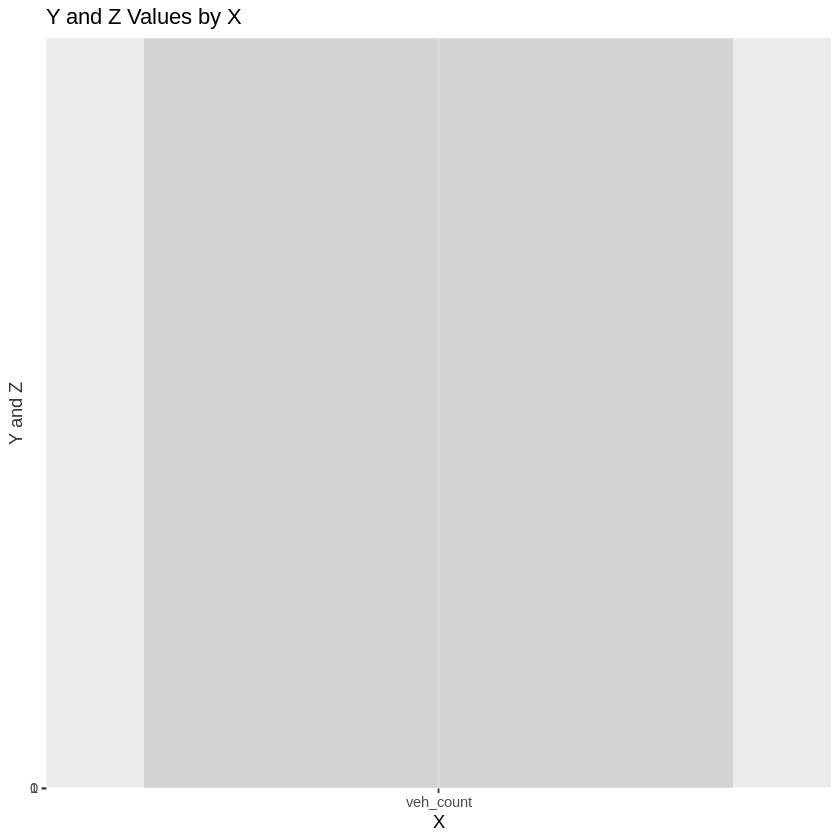

In [45]:
# I am having trouble in this part, Plotting 
my_data <- x_train
my_data$y_train <- y_train
my_data$pred_y_test_bin <- pred_y_test_bin

plot_y_z_on_right_axis <- function(my_data, x, y, z) {
# Plot y and z on right axis, with histogram of x
# Define y and z limits
y_lim <- c(min(my_data$y, na.rm = TRUE), max(my_data$y, na.rm = TRUE))
z_lim <- c(min(my_data$z, na.rm = TRUE), max(my_data$z, na.rm = TRUE))

ggplot(my_data, aes(x = x)) +
  geom_histogram(alpha = 0.5, fill = "grey", binwidth = 0.1, stat = "count") +
  geom_line(aes(y = y), color = "blue") +
  geom_point(aes(y = z), color = "red") +
  ggtitle("Y and Z Values by X") +
  xlab("X") +
  ylab("X Histogram") +
  scale_y_discrete(name = "Y and Z",
                   limits = c(y_lim[1], y_lim[2], z_lim[1], z_lim[2]),
                   labels = c("Y_min" = y_lim[1], "Y_max" = y_lim[2],
                              "Z_min" = z_lim[1], "Z_max" = z_lim[2])) + 
  theme(axis.title.y.right = element_text(color = "blue"),
        axis.text.y.right = element_text(color = "blue"),
        axis.title.y.left = element_text(color = "grey20"))

}

plot_y_z_on_right_axis(my_data, 'veh_count', 'y_train', 'pred_y_test_bin') 

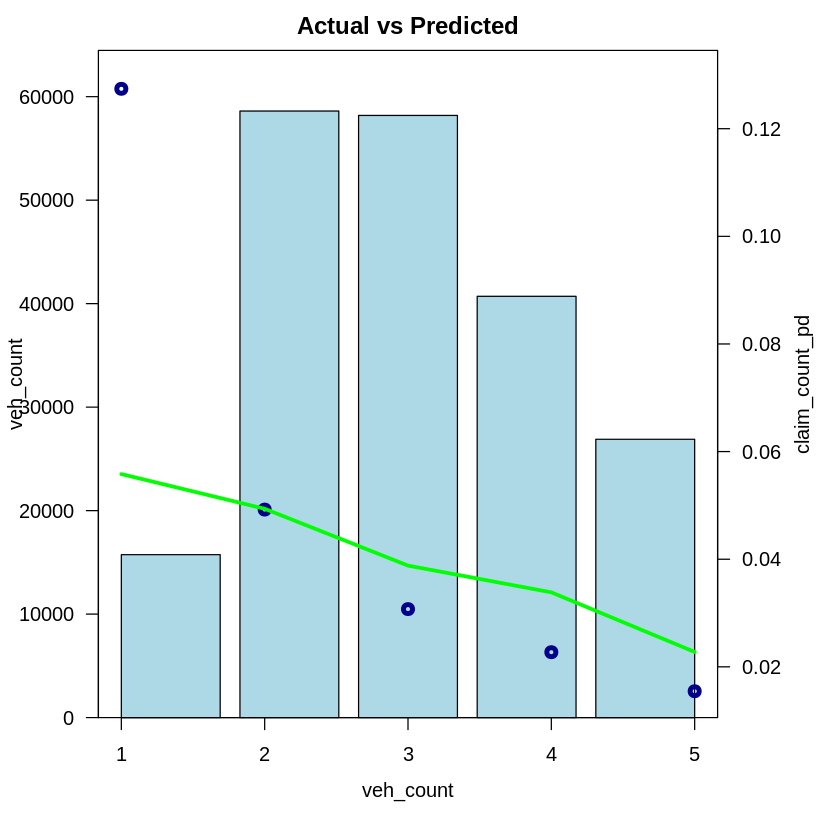

In [49]:
# I don't understand this code. Need to dig deeper
## resid.plot includes an off balance for when the model overall predicts low or high
resid.plot <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  pr1 = paste0(paste0(pred,'*'),weight)
  
  header = "Actual vs Predicted"
  
  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pr1)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  a3 = paste0("data$",weight)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)) * eval(parse(text = a3)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}
resid.plot(my_data,"veh_count","y_train","pred_y_test_bin","veh_count","claim_count_pd","veh_count")

#Calcualte the metric for each model

In [25]:
library(pROC)

# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GLM_top10$pred_y_test_bin, dataout_GLM_top10$y_test, "GLM Top 10"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [26]:
knitr::kable(metrics_df,digits = 2)



|var_name   | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|   TP|    FP|    TN|   FN| Samples|
|:----------|--------:|---------:|-----------:|--------:|---------:|----:|----:|-----:|-----:|----:|-------:|
|XGBoost    |     0.94|      0.64|        0.98|     0.78| 0.9586718| 0.92| 7844|  4370| 67610|  176|   80000|
|GLM Top 10 |     0.53|      0.13|        0.68|     0.23| 0.5973565| 0.19| 5476| 35132| 36848| 2544|   80000|
|GLM        |     0.54|      0.14|        0.67|     0.23| 0.5988378| 0.20| 5386| 34111| 37869| 2634|   80000|

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



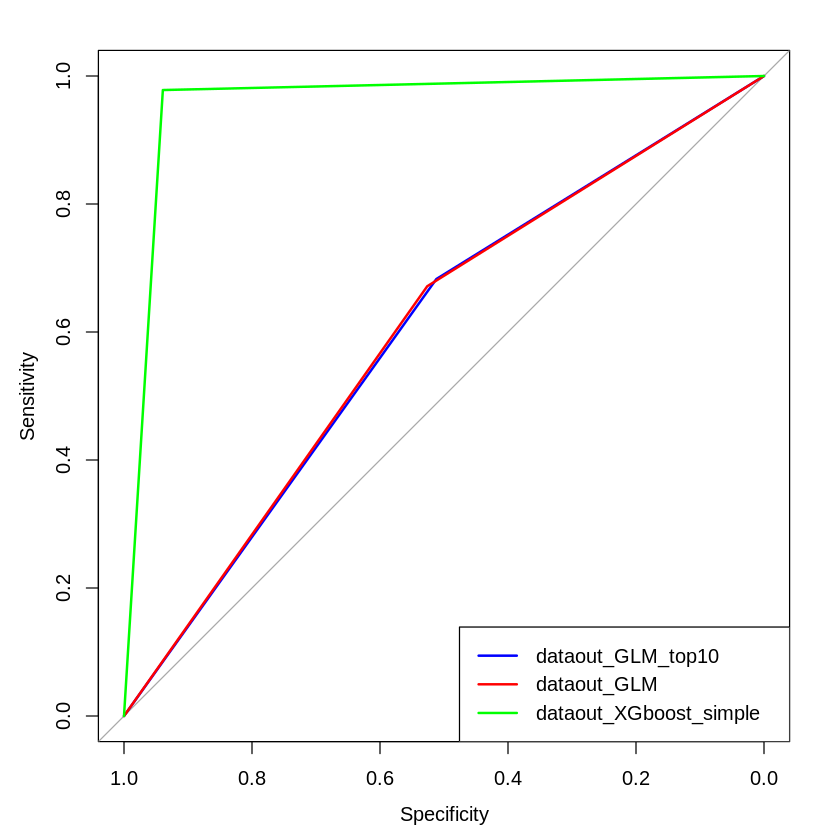

In [47]:
# Create a ROC curve
roc_curve1 <- roc(dataout_GLM_top10$y_test, dataout_GLM_top10$pred_y_test_bin)
roc_curve2 <- roc(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin)
roc_curve3 <- roc(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin)

# Plot the first ROC curve in blue
plot(roc_curve1, col = "blue")

# Add the second ROC curve in red
lines(roc_curve2, col = "red")
lines(roc_curve3, col = "green")
# Add a legend
legend("bottomright", legend = c("dataout_GLM_top10", "dataout_GLM","dataout_XGboost_simple"),
       col = c("blue", "red","green"), lwd = 2)

#Plot the various metrics as plots

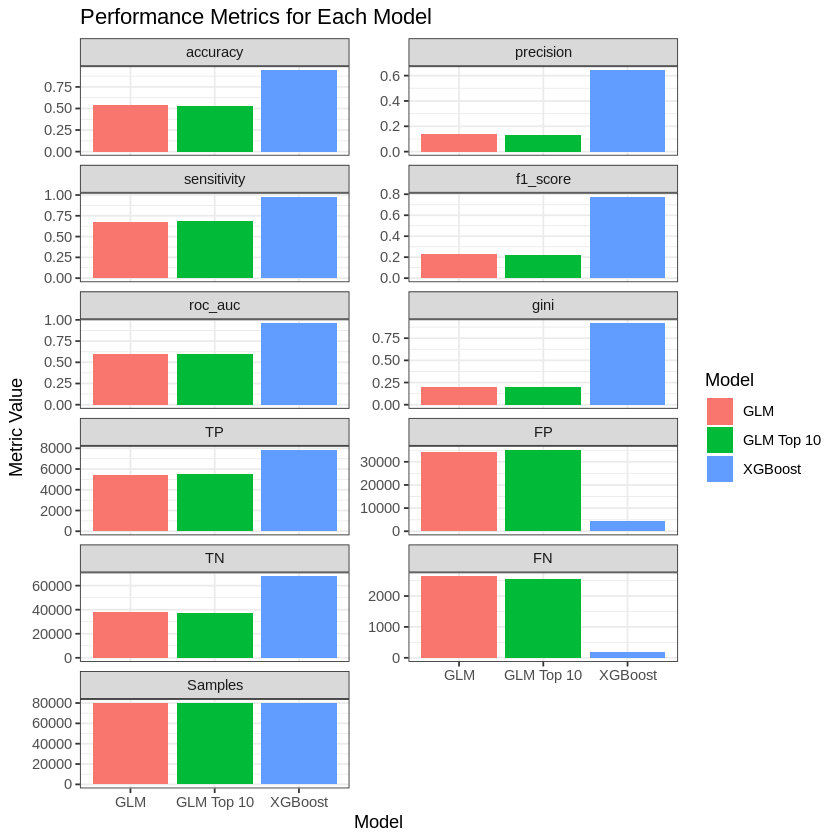

In [30]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

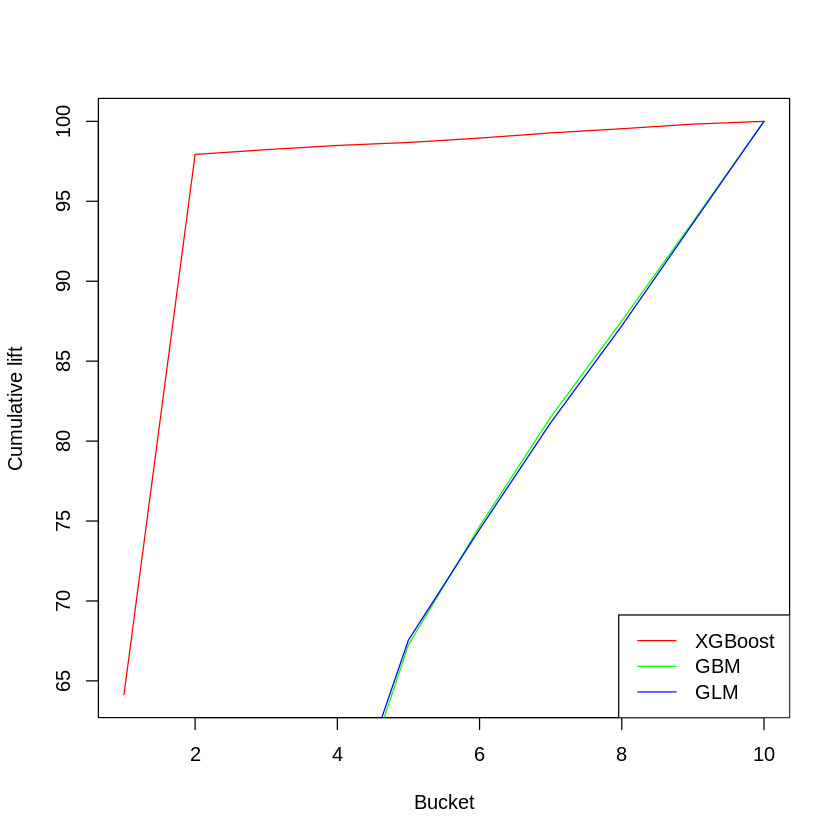

In [31]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GLM_top10$y_test, dataout_GLM_top10$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GBM", "GLM"), col=c("red", "green", "blue"), lty=1)

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)

In [ ]:
#library(flextable)
# Convert the data frame to a flextable object
ft_metrics <- flextable(metrics_df)
ft_metrics <- set_formatter(ft_metrics, type = "numeric", digits = 2) # Set the number of decimal places for numeric columns

ft_metrics <- set_header_labels(ft_metrics, var_name = "Model", Samples = "Total Samples")
ft_metrics <- autofit(ft_metrics)
ft_metrics <- add_header_row(ft_metrics, values = "Performance Metrics", merge = 11)
print(ft_metrics)

In [ ]:
# Convert the data frame to a gt object
gt_metrics <- gt(metrics_df)
cols_to_format <- c("accuracy", "precision", "sensitivity", "f1_score", "roc_auc", "gini")
gt_metrics <- data_color(gt_metrics, columns = cols_to_format, color = "white", apply_to = "text")
gt_metrics <- tab_style(gt_metrics, locations = cells_body(cols = cols_to_format), style = list(cell_text(weight = "bold", color = "black"), cell_fill(background.color = "gray")))
gt_metrics <- gt_metrics %>% tab_header(title = "Performance Metrics", subtitle = "for Each Model")

# Display the gt table
gt_metrics

In [ ]:
install.packages('h2o')
library(h2o) # For AutoML
h2o.init()